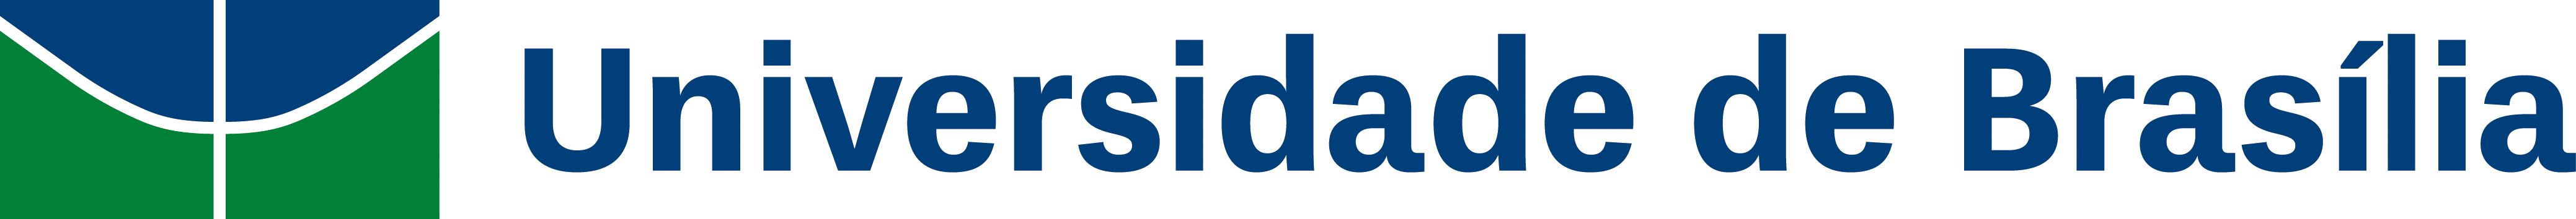
### Departamento de Ciência da Computação
---
# Projeto 1 - Introdução à Inteligência Artificial
#### Turma 01 - 2025/1 - Prof. Díbio
---
# Membros:
- João Vítor Maia - 190110007
- Mateus Lucas Oliveira Filho - 221000080
---

Este notebook demonstra:

1. Geração de dados fictícios
2. Pré-processamento e treinamento do modelo KNN
3. Avaliação de precisão@K e recall@K


## 1. Configurações e importações

In [ ]:
import random
import pandas as pd
from scipy.sparse import csr_matrix
import logging
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from data.source import CLIENTS, PRODUCTS, ORIGINAL_LOCATIONS, LOCATIONS_PRODUCTS, FEEDBACK_OPTIONS

# === Configurações do modelo ===
K_VIZINHOS = 20  # Quantidade de vizinhos similares a considerar
K_RECS = 10  # Número de itens a recomendar
ALPHA = 0.01  # Taxa de decaimento para ponderação de recência
MIN_PRODUCT_SUPPORT = 5  # Número mínimo de clientes que compraram um produto
MIN_CLIENT_TRANSACTIONS = 5  # Número mínimo de transações por cliente
MIN_QUANTITY = 5  # Quantidade mínima para considerar interação válida
# === Configurações de geração ===
NUM_ORDERS_PER_CLIENT = 100  # Quantidade de pedidos por cliente
MAX_DATE_OFFSET_DAYS = 365  # Intervalo máximo para datas futuras
OUTPUT_CSV_PATH = "data/sells_data.csv"  # Caminho de saída

## 2. Geração de dados fictícios

Função `generate_fake_sales`

In [ ]:
def generate_fake_sales() -> list[dict]:
    """
    Gera registros de vendas fictícias:
    - Cada cliente recebe NUM_ORDERS_PER_CLIENT entradas.
    - Produtos com histórico ou típicos da localidade têm maior probabilidade.
    - Quantidades são maiores para produtos regionais.
    - Datas são offset aleatório até MAX_DATE_OFFSET_DAYS dias.

    Retorna:
        Listagem de dicionários prontos para DataFrame.
    """
    sells = []
    base_date = pd.Timestamp.now().normalize()

    for idx, client in enumerate(CLIENTS):
        # Atribui localidade de forma cíclica
        location = ORIGINAL_LOCATIONS[idx % len(ORIGINAL_LOCATIONS)]

        # Histórico de produtos comprados para o cliente
        client_history = []

        for _ in range(NUM_ORDERS_PER_CLIENT):
            # Calcula pesos para escolha de produto
            weights = [
                100
                if p in client_history
                else 25
                if p in LOCATIONS_PRODUCTS.get(location, [])
                else 1
                for p in PRODUCTS
            ]
            product = random.choices(PRODUCTS, weights=weights, k=1)[0]

            # Define quantidade com base em regionalidade
            if product in LOCATIONS_PRODUCTS.get(location, []):
                quantity = random.randint(50, 100)
            else:
                quantity = random.randint(1, 10)

            # Simula data com deslocamento aleatório
            date = (
                base_date
                + pd.Timedelta(days=random.randint(0, MAX_DATE_OFFSET_DAYS))
                + pd.Timedelta(hours=random.randint(0, 23))
                + pd.Timedelta(minutes=random.randint(0, 59))
            )

            # Cria registro e atualiza histórico
            record = {
                "client": client,
                "location": location,
                "product": product,
                "quantity": quantity,
                "customerFeedback": random.choice(FEEDBACK_OPTIONS),
                "date": date,
            }
            sells.append(record)
            client_history.append(product)

    return sells


if __name__ == "__main__":
    # Gera dados e salva em CSV
    df_sales = pd.DataFrame(generate_fake_sales())
    df_sales.to_csv(OUTPUT_CSV_PATH, index=False, encoding="utf-8-sig")
    print(f"Geração de dados concluída. Arquivo salvo em '{OUTPUT_CSV_PATH}'.")


## 3. Pré-processamento e treinamento do modelo

In [ ]:
# === Configurações do modelo ===
K_VIZINHOS = 20  # Quantidade de vizinhos similares a considerar
K_RECS = 10  # Número de itens a recomendar
ALPHA = 0.01  # Taxa de decaimento para ponderação de recência
MIN_PRODUCT_SUPPORT = 5  # Número mínimo de clientes que compraram um produto
MIN_CLIENT_TRANSACTIONS = 5  # Número mínimo de transações por cliente
MIN_QUANTITY = 5  # Quantidade mínima para considerar interação válida

# === Logging ===
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# === Carregamento e preparação dos dados ===
logger.info("Carregando dados de vendas")
df_comp = pd.read_csv("data/sells_data.csv")

# Filtra interações de quantidade muito baixa
logger.info(f"Removendo interações com quantity < {MIN_QUANTITY}")
df_comp = df_comp[df_comp["quantity"] >= MIN_QUANTITY]

# Converte datas e calcula peso de recência
logger.info("Convertendo datas e calculando recência")
df_comp["date"] = pd.to_datetime(df_comp["date"])
max_date = df_comp["date"].max()
df_comp["days_since"] = (max_date - df_comp["date"]).dt.days
# Peso de recência decai com o tempo
df_comp["recency_weight"] = 1 / (1 + ALPHA * df_comp["days_since"])
# Aplica o peso ao volume comprado
df_comp["weighted_quantity"] = df_comp["quantity"] * df_comp["recency_weight"]

# === Filtragem de ruído geral ===
logger.info("Filtrando produtos esparsos e clientes com poucas transações")
support = df_comp.groupby("product")["client"].nunique()
popular_products = support[support >= MIN_PRODUCT_SUPPORT].index
df_comp = df_comp[df_comp["product"].isin(popular_products)]
txn_counts = df_comp["client"].value_counts()
active_clients = txn_counts[txn_counts >= MIN_CLIENT_TRANSACTIONS].index
df_comp = df_comp[df_comp["client"].isin(active_clients)]

# === Construção da matriz de características ===
logger.info("Gerando pivot table de cliente x produto (weighted_quantity)")
pivot = df_comp.pivot_table(
    index="client", columns="product", values="weighted_quantity", aggfunc="sum", fill_value=0
)

# Mapeia feedback qualitativo para escore numérico e adiciona média por cliente
logger.info("Mapeando feedback e adicionando avg_feedback")
feedback_map = {"Excelente": 5, "Bom": 4, "Regular": 3, "Ruim": 2, "Péssimo": 1}
df_comp["feedback_score"] = df_comp["customerFeedback"].map(feedback_map)
feedback_avg = df_comp.groupby("client")["feedback_score"].mean().rename("avg_feedback")
pivot = pivot.merge(feedback_avg, left_index=True, right_index=True)

# Converte pivot para matriz densa
dense_matrix = pivot.values

# Aplica TF–IDF para ajustar importância de produtos
logger.info("Aplicando TF-IDF nas features")
tfidf = TfidfTransformer()
tfidf_matrix = tfidf.fit_transform(dense_matrix)

# Normaliza vetores cliente para norma L2
logger.info("Normalizando vetores de cliente")
norm_matrix = normalize(tfidf_matrix, norm="l2", axis=1)

# Converte para matriz esparsa para o KNN
dense_norm = norm_matrix.toarray()  # OK para tamanhos moderados
df_sparse = csr_matrix(dense_norm)

# Atualiza variáveis globais
tt_clientes = pivot.index.tolist()
bursos = pivot.columns.tolist()

# === Treinamento do modelo KNN ===
logger.info("Treinando modelo NearestNeighbors")
knn = NearestNeighbors(n_neighbors=K_VIZINHOS, metric="cosine", algorithm="brute")
knn.fit(df_sparse)
logger.info("Modelo treinado com sucesso")

# === Funções de recomendação e histórico ===


def recomendar_por_cliente(client: str, k_vizinhos: int = K_VIZINHOS, k_recs: int = K_RECS) -> list:
    """
    Recomenda produtos para um cliente com base em vizinhos mais similares.

    Args:
        client: identificador do cliente.
        k_vizinhos: número de clientes vizinhos a considerar.
        k_recs: número de itens recomendados.

    Returns:
        Lista de produtos recomendados.
    """
    if client not in tt_clientes:
        logger.error(f"Cliente não encontrado: {client}")
        raise ValueError(f"Cliente '{client}' não encontrado.")

    idx = tt_clientes.index(client)
    dist, viz_idx = knn.kneighbors(df_sparse[idx], n_neighbors=k_vizinhos + 1)
    vizinhos_list = viz_idx[0].tolist()
    if idx in vizinhos_list:
        vizinhos_list.remove(idx)
    vizinhos_list = vizinhos_list[:k_vizinhos]

    scores = np.array(df_sparse[vizinhos_list].sum(axis=0)).ravel()
    top_idx = np.argsort(scores)[::-1][:k_recs]
    return [bursos[i] for i in top_idx]


def get_client_purchases(client: str) -> list[dict]:
    """
    Retorna o histórico de compras de um cliente.
    """
    if client not in tt_clientes:
        raise ValueError(f"Cliente '{client}' não encontrado.")
    df_client = df_comp[df_comp["client"] == client]
    df_sorted = df_client.sort_values("quantity", ascending=False)
    return df_sorted[["product", "quantity"]].to_dict("records")


# Exemplo de execução
if __name__ == "__main__":
    sample = tt_clientes[0] if tt_clientes else None
    if sample:
        print(recomendar_por_cliente(sample))

## 4. Avaliação do modelo

Implementação de `avaliar_knn_v2`

In [ ]:
def avaliar_knn_v2(
    df_comp: pd.DataFrame,
    recomendar_fn,
    k_vizinhos: int = K_VIZINHOS,
    k_recs: int = K_RECS,
    test_frac: float = 0.1,
) -> dict:
    """
    Avalia o desempenho do modelo KNN considerando recência e feedback:
      - Separa uma fração de interações de cada cliente para teste.
      - Reajusta o KNN nos dados de treino (ponderados por recência e com feedback médio).
      - Gera recomendações e calcula precision@K e recall@K.
    """
    # Cópia dos dados e marcação de amostras de teste
    df = df_comp.copy()
    df["is_test"] = False
    for cliente, grp in df.groupby("client"):
        n_test = max(1, int(len(grp) * test_frac))
        idxs = grp.sample(n=n_test, random_state=42).index
        df.loc[idxs, "is_test"] = True

    # Separação em treino e teste
    df_train = df[~df["is_test"]]
    df_test = df[df["is_test"]]

    # Pivot dos dados de treino: utiliza weighted_quantity (recência) e adiciona avg_feedback
    pivot_train = df_train.pivot_table(
        index="client", columns="product", values="weighted_quantity", aggfunc="sum", fill_value=0
    )
    feedback_avg = df_train.groupby("client")["feedback_score"].mean().rename("avg_feedback")
    pivot_train = pivot_train.merge(feedback_avg, left_index=True, right_index=True)

    # Converte para matriz esparsa e refaz o KNN
    clientes = pivot_train.index.to_list()
    produtos = pivot_train.columns.to_list()
    mat_train = csr_matrix(pivot_train.values)
    knn.fit(mat_train)

    # Atualiza globais usados por recomendar_por_cliente
    global pivot, localidades, itens, mat_sparse
    pivot = pivot_train
    localidades = clientes
    itens = produtos
    mat_sparse = mat_train

    precisions, recalls = [], []
    # Avaliação de cada cliente no teste
    for cliente in df_test["client"].unique():
        itens_test = df_test.loc[df_test["client"] == cliente, "product"].unique().tolist()
        if not itens_test:
            continue
        recs = recomendar_fn(cliente, k_vizinhos=k_vizinhos, k_recs=k_recs)
        hits = set(recs) & set(itens_test)
        precisions.append(len(hits) / k_recs)
        recalls.append(len(hits) / len(itens_test))

    return {
        "precision@K": float(np.mean(precisions)) if precisions else 0.0,
        "recall@K": float(np.mean(recalls)) if recalls else 0.0,
    }

In [ ]:
if __name__ == "__main__":
    metrics = avaliar_knn_v2(df_comp, recomendar_por_cliente)
    print(metrics)

## Conclusão

Este notebook executou uma única iteração do testbench com: geração de dados, treinamento e avaliação do modelo KNN para recomendações.

Agora você pode:

1. utilizar o `grid_search.py` para encontrar os melhores parâmetros e depois de introduzi-los no `ai.py`

2. executar o `testbench.py` para encontrar o melhor caso-base.